# Reading BODC and model data for each mooring. Writing NC files with temperature at same time and depth for both

** Summary: **
Reading BODC and model data for each mooring. Writing NC files with temperature at same time and depth for both

** Problems/To do **
* This and that

** Notebook: ** Comparison_mod_obs.ipynb

** Author: ** kariho40 27 dec 2015

** Changelog: **
* 27 Dec 2015 (kariho40): get started
* 20 Jan 2016 (jelt): add heading information. Generalise/automate some user defined paths. Sorted out an interpolate issue at edges of valid data.


In [1]:
## Import the libraries

import numpy as np
import numpy.ma as ma
from scipy.io import netcdf
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt  # plotting
from sympy import * 
from __future__ import division
import bodc_data_tools

init_printing()  # for sympy
%matplotlib inline

## Personal librairies
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/login/jelt/matlab/mfiles/ipynb/fastnet')
import bodc_data_tools
import h5py
import amm60_data_tools


######### Personal Paths #############
HOME = '/media/karen/data1/'
CRUISE_DIR = HOME + 'AMM60/FASTNEt/BODC_fastnet/'
AMM60_DIR = HOME + 'AMM60/RUN_nodiff_2012/'
AMM7_DIR = HOME + 'AMM7/2012/'
#NNA_DIR = HOME + 'NNA/2012/'
#CSV_FILENAME = 'bodc_series_metadata_summary.csv'
WRITEDIR = HOME + 'AMM60/FASTNEt'
MOORING_NAMES = ['SE']


# Path fixes while developing and debugging #
import getpass
user = getpass.getuser()
print(user)

if 'jelt' in user:
    HOME = '/projectsa/FASTNEt/kariho40/OBS/BODC_FASTNEt_data/'
    MOORINGmod_filename = '/projectsa/FASTNEt/kariho40/AMM60/RUNS/D376/AMM60_1h_fastnet_ST1.nc'
    MOORINGobs_filename = '/scratch/jelt/mooring_0.nc'
    MOORING_merged_filename = '/scratch/jelt/mooring_ST1_temp.nc'
elif 'karen' in user:
    ######### Personal Paths #############
    HOME = '/media/karen/data1/'
    CRUISE_DIR = HOME + 'AMM60/FASTNEt/BODC_fastnet/'
    AMM60_DIR = HOME + 'AMM60/FASTNEt/BODC_fastnet/'
    AMM7_DIR = HOME + 'AMM60/FASTNEt/BODC_fastnet/'
    NNA_DIR = HOME + 'AMM60/FASTNEt/BODC_fastnet/'
    #CSV_FILENAME = 'bodc_series_metadata_summary.csv'
    WRITEDIR = HOME + 'AMM60/FASTNEt/'
    MOORING_NAMES = ['SE']
else:
    print "Don't panic! "+user+" not set up for pathname settings"
        


karen


### Loading the observed data

In [7]:
## Load OBS data
for index in range(len(MOORING_NAMES)):
    MOORING_NAME = MOORING_NAMES[index]
    print(MOORING_NAME)
    
    filepath_mod = AMM60_DIR + 'AMM60_1h_20130615_20130813_fastnet_' + MOORING_NAME + '_grid_T.nc'
    MOORING_merged_filename = '/media/karen/data1/AMM60/FASTNEt/AMM60/mooring_' + MOORING_NAME + '.nc'
    [temp_obs,time_obs,depth_obs] = bodc_data_tools.readBodcMooringTemp(MOORING_NAME,CRUISE_DIR)
    indtime_st=0
    indtime_en=1440
    [temp_mod,time_mod,depth_mod,longitude,latitude] = amm60_data_tools.readNCmooring_hdf5(filepath_mod,indtime_st,indtime_en)
    [temp_mod_interp,temp_obs_interp,time_lev,depth_lev] = amm60_data_tools.interpMooringModelData(temp_mod,time_mod,depth_mod,temp_obs,time_obs,depth_obs)
    amm60_data_tools.writeNCmodelobs(MOORING_merged_filename,time_lev,depth_lev,longitude,latitude,temp_mod_interp,temp_obs_interp)

    filepath_mod = AMM7_DIR + 'amm7_1h_20130701_20130731_fastnet_' + MOORING_NAME + '_grid_T.nc'
    MOORING_merged_filename = '/media/karen/data1/AMM60/FASTNEt/AMM7/mooring_' + MOORING_NAME + '.nc'
    [temp_mod,time_mod,depth_mod,longitude,latitude] = amm60_data_tools.readNCmooring_hdf5(filepath_mod,indtime_st,indtime_en)
    [temp_mod_interp,temp_obs_interp,time_lev,depth_lev] = amm60_data_tools.interpMooringModelData(temp_mod,time_mod,depth_mod,temp_obs,time_obs,depth_obs)
    amm60_data_tools.writeNCmodelobs(MOORING_merged_filename,time_lev,depth_lev,longitude,latitude,temp_mod_interp,temp_obs_interp)

    print('NNA')
    indtime_st=0
    indtime_en=8760
    filepath_mod = NNA_DIR + 'NNA_ERA_ZPS_TIDE_1h_20130101_20131231_grid_T_FAST_' + MOORING_NAME + '.nc'
    MOORING_merged_filename = '/media/karen/data1/AMM60/FASTNEt/NNA/mooring_' + MOORING_NAME + '.nc'
    [temp_mod,time_mod_delay,depth_mod,longitude,latitude] = amm60_data_tools.readNCmooring_nna(filepath_mod,indtime_st,indtime_en)
    time_mod = time_mod_delay
    print(time_mod.min()/86400)
    [temp_mod_interp,temp_obs_interp,time_lev,depth_lev] = amm60_data_tools.interpMooringNNAData(temp_mod,time_mod,depth_mod,temp_obs,time_obs,depth_obs)
    time_lev_1950 = time_lev +366*30 -143
    amm60_data_tools.writeNCmodelobs(MOORING_merged_filename,time_lev_1950,depth_lev,longitude,latitude,temp_mod_interp,temp_obs_interp)
    
    
    
    
    
    
    


SE
NNA
12174.0208333


Instead of masking out zero values:

`temp_obs = ma.masked_where(raw_temp_obs == 0, temp_obs)`

 which then causes problems in the interpolation routine, chop them out.

However, editing the array loaded from the nc file is not always allowed:

`temp_obs.flags.writeable = True` 

Is not permitted.

Instead copy the array and set bad points to NaN.

Also you have to mask out the data to pcolormesh

### Plot the interpolated data

/home/karen/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


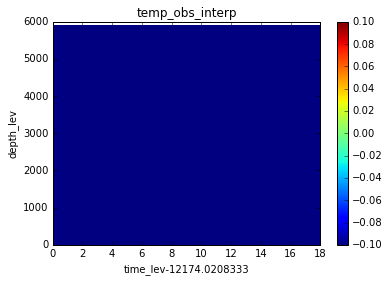

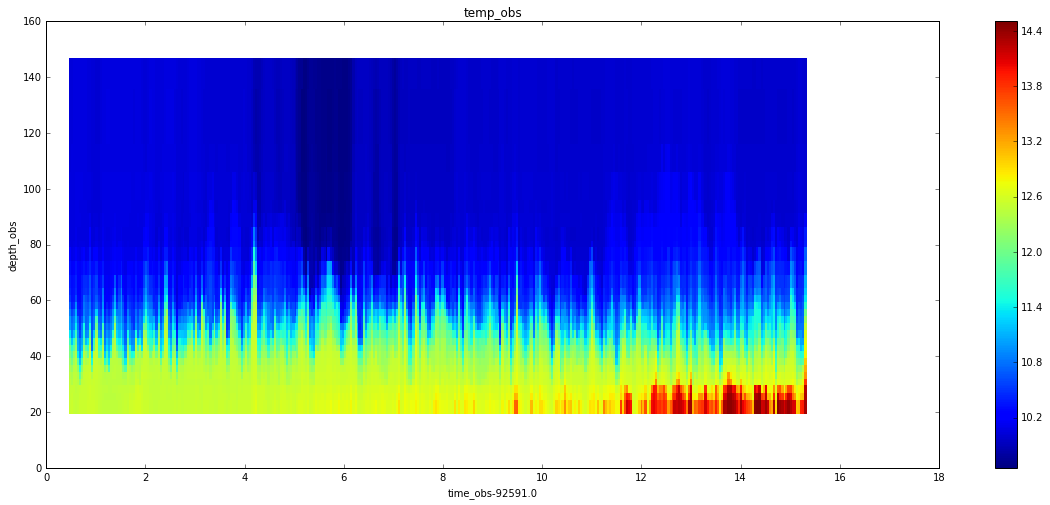

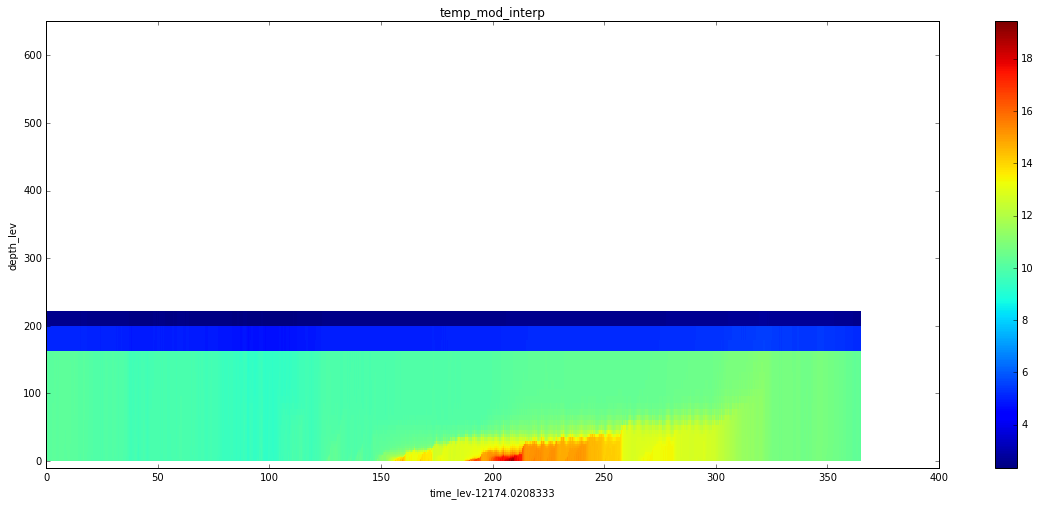

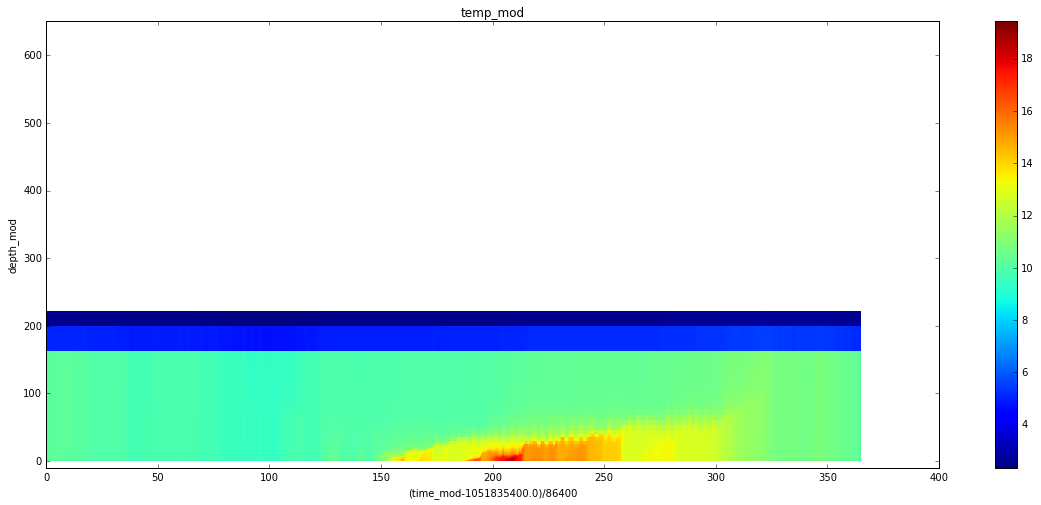

In [6]:
fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.pcolormesh(time_lev-time_lev[0],depth_lev,temp_obs_interp)
plt.xlim(0,18)
plt.colorbar()
plt.xlabel('time_lev-'+str(time_lev[0]))
plt.ylabel('depth_lev')
plt.title('temp_obs_interp')

fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.pcolormesh(time_obs-time_obs[0],depth_obs,temp_obs)
plt.xlim(0,18)
plt.xlabel('time_obs-'+str(time_obs[0]))
plt.ylabel('depth_obs')
plt.title('temp_obs')
plt.colorbar()

fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.pcolormesh(time_lev-time_lev[0],depth_lev,temp_mod_interp)
plt.ylim(-10, 650)
plt.colorbar()
plt.xlabel('time_lev-'+str(time_lev[0]))
plt.ylabel('depth_lev')
plt.title('temp_mod_interp')

fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.pcolormesh((time_mod-time_mod[0])/86400,depth_mod,temp_mod)
plt.ylim(-10, 650)
plt.xlabel('(time_mod-'+str(time_mod[0])+')/86400')
plt.ylabel('depth_mod')
plt.title('temp_mod')
plt.colorbar()

NameError: name 'time_obs_1950' is not defined

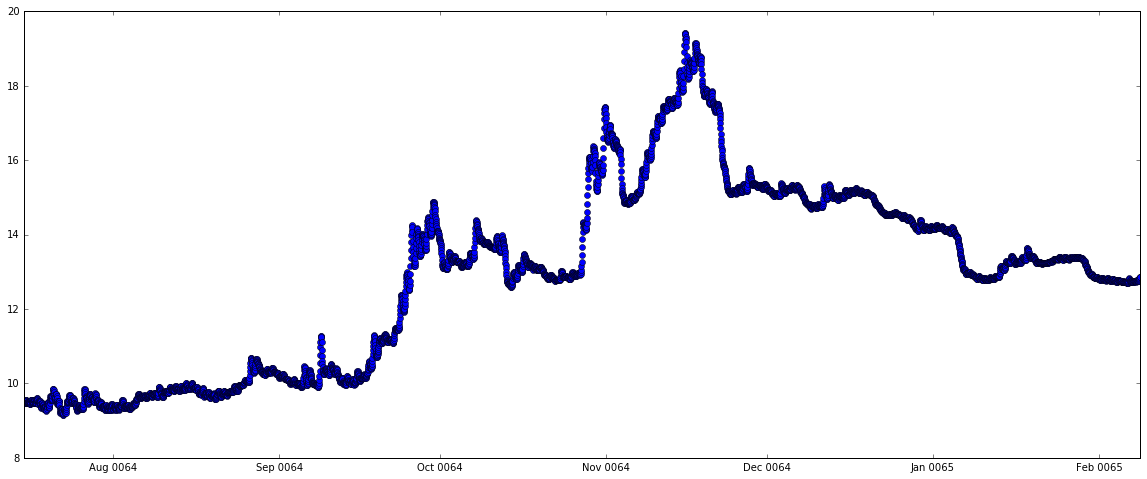

In [4]:
fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.plot_date(time_lev,temp_mod[0,:])
plt.plot_date(time_obs_1950,temp_obs[0,:],'r.')
plt.xlabel('time_lev')
plt.title('Surface temperatures - not interpolated')
plt.legend(['temp_mod','temp_obs'],loc='best')



fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.plot_date(time_lev,temp_mod_interp[0,:])
plt.plot_date(time_lev,temp_obs_interp[0,:],'r.')
plt.xlabel('time_lev')
plt.title('Surface temperatures - interpolated')
plt.legend(['temp_mod_interp','temp_obs_interp'],loc='best')
